In [33]:
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.pyplot as plt
import glob as glob
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
import collections

In [2]:
from get_industries_func import extract_keyword_count, get_industries, new_categories

In [3]:
# nltk.download('stopwords')

## 1.Data EDA

In [4]:
raw_data = pd.read_csv('data_scientist_united_states_job_postings_jobspikr.csv')

In [5]:
raw_data.head()

,crawl_timestamp,url,job_title,category,company_name,city,state,country,inferred_city,inferred_state,...,job_description,job_type,salary_offered,job_board,geo,cursor,contact_email,contact_phone_number,uniq_id,html_job_description
0,2019-02-06 05:26:22 +0000,https://www.indeed.com/viewjob?jk=fd83355c2b23...,Enterprise Data Scientist I,Accounting/Finance,Farmers Insurance Group,Woodland Hills,CA,Usa,Woodland hills,California,...,Read what people are saying about working here...,Undefined,NaN,indeed,usa,1549432819114777,NaN,NaN,3b6c6acfcba6135a31c83bd7ea493b18,NaN
1,2019-02-06 05:33:41 +0000,https://www.dice.com/jobs/detail/Data-Scientis...,Data Scientist,NaN,Luxoft USA Inc,Middletown,NJ,Usa,Middletown,New jersey,...,We have an immediate opening for a Sharp Data ...,Undefined,NaN,dice,usa,1549432819122106,NaN,NaN,741727428839ae7ada852eebef29b0fe,NaN
2,2019-02-06 05:33:35 +0000,https://www.dice.com/jobs/detail/Data-Scientis...,Data Scientist,NaN,Cincinnati Bell Technology Solutions,New York,NY,Usa,New york,New york,...,Candidates should have the following backgroun...,Full Time,NaN,dice,usa,1549432819236156,NaN,NaN,cdc9ef9a1de327ccdc19cc0d07dbbb37,NaN
3,2019-02-06 05:33:42 +0000,https://www.indeed.com/viewjob?jk=841edd86ead2...,"Data Scientist, Aladdin Wealth Tech, Associate...",Accounting/Finance,BlackRock,New York,NY 10055 (Midtown area),Usa,New york,New york,...,Read what people are saying about working here...,Undefined,NaN,indeed,usa,1549432819259473,NaN,NaN,1c8541cd2c2c924f9391c7d3f526f64e,NaN
4,2019-02-06 05:48:23 +0000,https://job-openings.monster.com/senior-data-s...,Senior Data Scientist,biotech,CyberCoders,Charlotte,NC,Usa,Charlotte,North carolina,...,We are seeking an extraordinary Data Scientist...,Full Time,NaN,monster,usa,1549436429015957,NaN,NaN,445652a560a5441060857853cf267470,NaN


In [6]:
data = raw_data.drop(columns=['url', 'inferred_city', 'inferred_state', 'job_type', 'salary_offered',
                              'job_board', 'geo', 'contact_email','contact_phone_number', 'html_job_description'])

In [7]:
data.shape

(10000, 12)

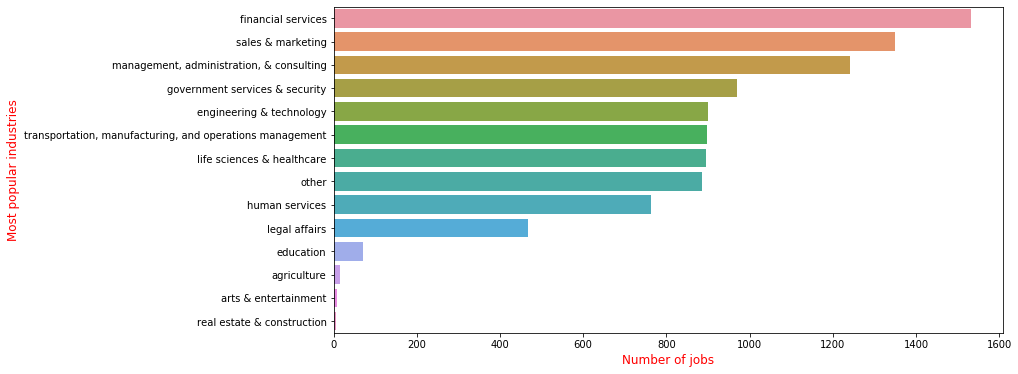

In [8]:
# map categories to ten categories using our defined functions
new_cat = new_categories(data)
data['category'] = new_cat['category']

In [9]:
data.head()

,crawl_timestamp,job_title,category,company_name,city,state,country,inferred_country,post_date,job_description,cursor,uniq_id
0,2019-02-06 05:26:22 +0000,Enterprise Data Scientist I,financial services,Farmers Insurance Group,Woodland Hills,CA,Usa,Usa,2019-02-06,Read what people are saying about working here...,1549432819114777,3b6c6acfcba6135a31c83bd7ea493b18
1,2019-02-06 05:33:41 +0000,Data Scientist,other,Luxoft USA Inc,Middletown,NJ,Usa,Usa,2019-02-05,We have an immediate opening for a Sharp Data ...,1549432819122106,741727428839ae7ada852eebef29b0fe
2,2019-02-06 05:33:35 +0000,Data Scientist,other,Cincinnati Bell Technology Solutions,New York,NY,Usa,Usa,2019-02-05,Candidates should have the following backgroun...,1549432819236156,cdc9ef9a1de327ccdc19cc0d07dbbb37
3,2019-02-06 05:33:42 +0000,"Data Scientist, Aladdin Wealth Tech, Associate...",financial services,BlackRock,New York,NY 10055 (Midtown area),Usa,Usa,2019-02-06,Read what people are saying about working here...,1549432819259473,1c8541cd2c2c924f9391c7d3f526f64e
4,2019-02-06 05:48:23 +0000,Senior Data Scientist,life sciences & healthcare,CyberCoders,Charlotte,NC,Usa,Usa,2019-02-05,We are seeking an extraordinary Data Scientist...,1549436429015957,445652a560a5441060857853cf267470


### Data Exploration

In [10]:
# drop NA rows
data_com = data[pd.notnull(data['company_name'])]

Toatl number of firms 4137
Top 25 firms with most vacancies                                   company_name  job_title
1350                               CyberCoders        628
2197                           Jefferson Frank        259
2667              Nigel Frank International US         88
552                        Booz Allen Hamilton         77
3482                                   Taboola         77
331                               Apex Systems         72
2285                         Kforce Technology         71
3587                           The Judge Group         67
3305  Social Science Research Solutions (SSRS)         67
3142                    Robert Half Technology         63
3464                           TEKsystems, Inc         61
1616                                  Facebook         56
1984                                       IBM         52
2238                                      KPMG         49
2339                                    Leidos         49
3071        

Text(0, 0.5, 'Companies with most job positions')

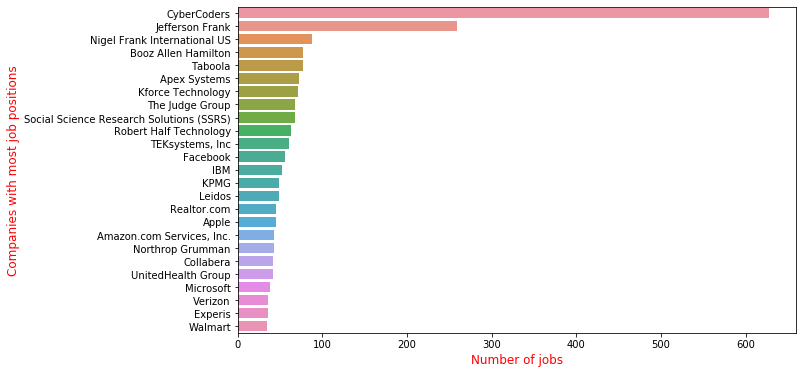

In [11]:
num_company=data_com['company_name'].nunique()
print('Toatl number of firms',num_company)

#finding highest number of vacancy in a company
company=data_com.groupby(['company_name'])['job_title'].count()
company=company.reset_index()
company=company.sort_values(['job_title'],ascending=False)
print('Top 25 firms with most vacancies',company.head(25))

fig, ax = plt.subplots(figsize = (10,6))
ax=seaborn.barplot(x="job_title", y="company_name", data=company.head(25))    
# ax.set_xticklabels(company['company_name'])  
ax.set_xlabel('Number of jobs',fontsize=12, color='red')
ax.set_ylabel('Companies with most job positions',fontsize=12,color='red')

In [12]:
data_cat = data[pd.notnull(data['category'])]

Toatl number of categoris across all the firms 14
Top 30 most popular categories                                              category  company_name
4                                  financial services          1533
12                                  sales & marketing          1348
9            management, administration, & consulting          1242
5                      government services & security           969
3                            engineering & technology           900
13  transportation, manufacturing, and operations ...           897
8                          life sciences & healthcare           895
10                                              other           886
6                                      human services           763
7                                       legal affairs           467
2                                           education            70
0                                         agriculture            15
1                                ar

Text(0, 0.5, 'Most popular industries')

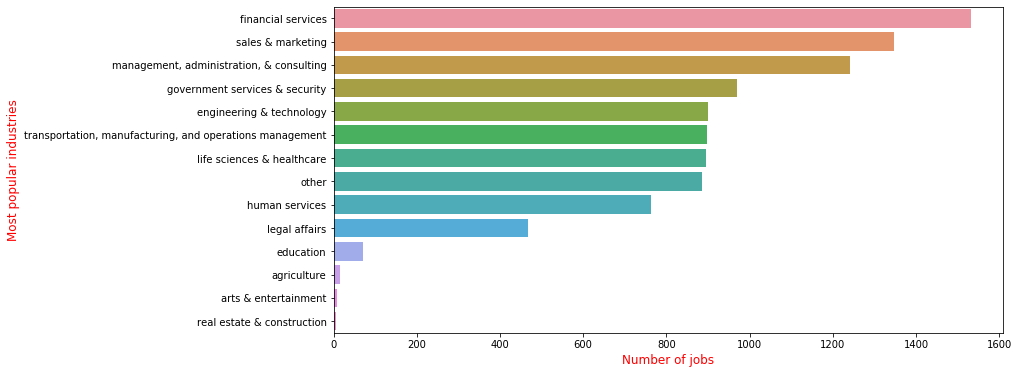

In [13]:
# Finding total number of unique categories
total_cat=data_cat['category'].nunique()
print('Toatl number of categoris across all the firms',total_cat)
# most popular industries
indus=data_cat.groupby(['category'])['company_name'].count()
indus=indus.reset_index()
indus=indus.sort_values(['company_name'],ascending=False)   
print('Top 30 most popular categories',indus)

fig,ax=plt.subplots(figsize=(12,6))
ax=seaborn.barplot(x="company_name", y="category", data=indus.head(30))    
# ax.set_xticklabels(indus['category'],rotation=90)
ax.set_xlabel('Number of jobs',fontsize=12,color='red')
ax.set_ylabel('Most popular industries',fontsize=12,color='red')

### Project Cities on U.S. Map

## 2. Word Preprocessing and NLP

### Data Cleasing

In [14]:
mapper = {'apache spark':'spark', 'math':'mathematics', 'applied mathematics':'mathematics', 
          'nlp':'natural language processing', 'advanced analytics':'analytics', 'applied math':'mathematics',
          'aws':'amazon web services',  'data analytics': 'analytics', 'sql server':'sql' , 
          'git': 'github', 'cs':'computer science', 'ml': 'machine learning', 'big': 'big data',
          'sql experience': 'sql', 'dl': 'deep learning', 'business analytics': 'analytics',
          'powerbi': 'power bi', 'r experience': 'r',
          'office':'microsoft office', 'python experience':'python', 'applied statistics': 'statistics',
          'ms office':'microsoft office', 'azure':'microsoft azure', 'predictive analytics': 'analytics'}


In [15]:
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['equal', 'opportunity','employer','race', 'color',
                'religion', 'sexual', 'orientation', 'gender', 
                'gender','identity', 'employment', 'without',
                'regard','color','religion', 'sex', 'summary', 'location', 
                'employment', 'consideration', 'veteran','sex',
                'nation','origin','protected','applicants','receive',
                'national', 'disability', 'read','people','saying','about','what','working',
                'full','time','employee','status', 'posted', 'today', 'scientist', 'science','data',
               'using','work','related','field']
stop_words.extend(newStopWords)

In [16]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
def pre_process(text):
    # lowercase
    text=text.lower()
    # remove http links
    text = re.sub(r"http\S+", "", text)
    # remove non-alphanumeric char
    text = re.sub(r"[^a-zA-Z0-9]+", ' ',text)
    text = text.split(' ')
    mapped = [mapper[word] if (word in mapper) else word for word in text if word not in stop_words]
    return mapped

In [18]:
data = data[pd.notnull(data['job_description'])]
data.job_description = data.job_description.apply(lambda x:pre_process(x))
data.job_description.head(10)

0    [farmers, join, team, diverse, professionals, ...
1    [immediate, opening, sharp, strong, mathematic...
2    [candidates, following, background, skills, ch...
3    [blackrock, blackrock, helps, investors, build...
4    [seeking, extraordinary, charlotte, join, fast...
5    [join, new, york, team, analyst, associate, vp...
6    [spotify, mission, provide, world, best, platf...
7    [job, title, sr, consultant, duration, 1, yrs,...
8    [blackrock, blackrock, helps, investors, build...
9    [, 3, years, professional, experience, proven,...
Name: job_description, dtype: object

In [19]:
data.head()

,crawl_timestamp,job_title,category,company_name,city,state,country,inferred_country,post_date,job_description,cursor,uniq_id
0,2019-02-06 05:26:22 +0000,Enterprise Data Scientist I,financial services,Farmers Insurance Group,Woodland Hills,CA,Usa,Usa,2019-02-06,"[farmers, join, team, diverse, professionals, ...",1549432819114777,3b6c6acfcba6135a31c83bd7ea493b18
1,2019-02-06 05:33:41 +0000,Data Scientist,other,Luxoft USA Inc,Middletown,NJ,Usa,Usa,2019-02-05,"[immediate, opening, sharp, strong, mathematic...",1549432819122106,741727428839ae7ada852eebef29b0fe
2,2019-02-06 05:33:35 +0000,Data Scientist,other,Cincinnati Bell Technology Solutions,New York,NY,Usa,Usa,2019-02-05,"[candidates, following, background, skills, ch...",1549432819236156,cdc9ef9a1de327ccdc19cc0d07dbbb37
3,2019-02-06 05:33:42 +0000,"Data Scientist, Aladdin Wealth Tech, Associate...",financial services,BlackRock,New York,NY 10055 (Midtown area),Usa,Usa,2019-02-06,"[blackrock, blackrock, helps, investors, build...",1549432819259473,1c8541cd2c2c924f9391c7d3f526f64e
4,2019-02-06 05:48:23 +0000,Senior Data Scientist,life sciences & healthcare,CyberCoders,Charlotte,NC,Usa,Usa,2019-02-05,"[seeking, extraordinary, charlotte, join, fast...",1549436429015957,445652a560a5441060857853cf267470


In [20]:
descrip = data.job_description

In [21]:
# all_text = [sentence for sentence in descrip]
# all_text = ' '.join(all_text)
# all_text = [*sentence for sentence in descrip]
import itertools
all_text = itertools.chain.from_iterable(descrip)
all_text = ' '.join(all_text)

### Wordcloud

In [29]:
def wordcloud(text, max_words=30, max_font_size=50, figure_size=(10,10), 
                   title = None, title_size=20):

    wordcloud = WordCloud(background_color='white',
                    stopwords = stop_words,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400)
    wordcloud.generate(text)
    #set the plot parameters
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

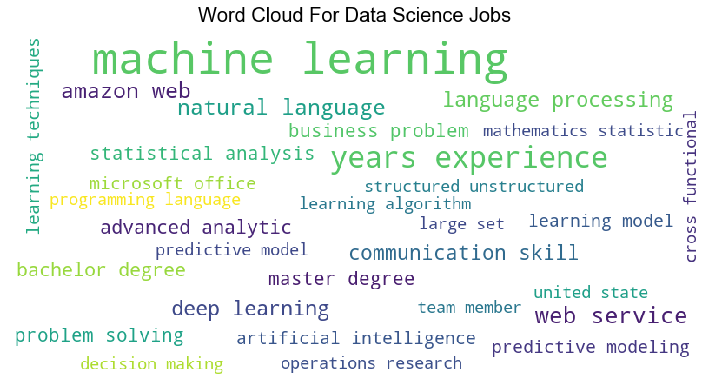

In [36]:
wordcloud(all_text, max_words=30, title='Word Cloud For Data Science Jobs')

### N-grams

In [24]:
def ngrams(sentence, n):
    '''
    returns ngrams of the sentence
    :param n: number of grams
    '''
    token = [token for token in sentence if token not in stop_words and len(token)>1]
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

In [25]:
def ngrams_generator(dataframe, n, num_keep):
    '''
    returns phrase rank with frequencies.
    :param num_grams_: number of grams
    :param num_keep: number of top phrases to keep
    '''
    dic = collections.defaultdict(int)
    for sentence in dataframe:
        for word in ngrams(sentence, n):
            dic[word] += 1
    ordered = collections.OrderedDict(sorted(dic.items(),key=lambda x: x[1], reverse=True))
    top_phrase = [i for i in ordered.keys()]
    count = [j for j in ordered.values()]
    print(top_phrase[:num_keep])
    print(count[:num_keep])
    return top_phrase[:num_keep], count[:num_keep]

['experience', 'business', 'learning', 'analytics', 'team', 'machine', 'analysis', 'skills', 'models', 'years', 'ability', 'solutions', 'statistical', 'knowledge', 'new', 'tools', 'development', 'job', 'research', 'technical']
[59197, 33919, 27304, 21991, 21155, 20770, 20672, 19824, 16563, 16253, 15687, 15122, 14695, 13271, 12781, 12777, 12774, 12485, 12298, 12244]


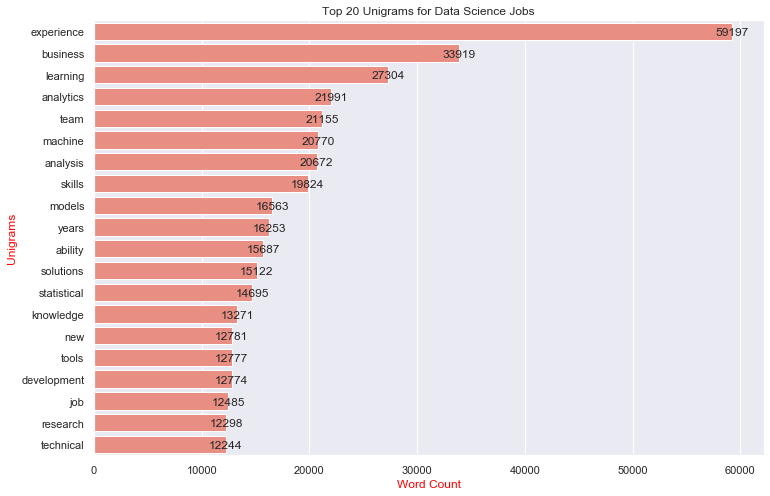

In [37]:
#barplot top phrases
# unigram
phrase, count = ngrams_generator(descrip, 1, 20)

plt.figure(figsize=(12,8))

sns.set(style="darkgrid")
sns.set_color_codes("muted")

# Create barplot 
ax = sns.barplot(count, phrase, color="salmon", orient='h')
# Annotate every single Bar with its value, based on it's width           
for p in ax.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')

plt.xlabel("Word Count", fontsize=12, color='red')
plt.ylabel("Unigrams", fontsize=12, color='red')
plt.title("Top 20 Unigrams for Data Science Jobs")
plt.show()

['machine learning', 'years experience', 'deep learning', 'communication skills', 'bachelor degree', 'advanced analytics', 'master degree', 'problem solving', 'statistical analysis', 'business problems', 'predictive modeling', 'artificial intelligence', 'learning techniques', 'natural language', 'operations research', 'mathematics statistics', 'predictive models', 'language processing', 'decision making', 'learning models']
[20329, 8328, 3438, 3437, 3133, 2871, 2734, 2671, 2620, 2578, 2316, 2286, 2120, 2057, 2049, 1917, 1898, 1853, 1842, 1817]


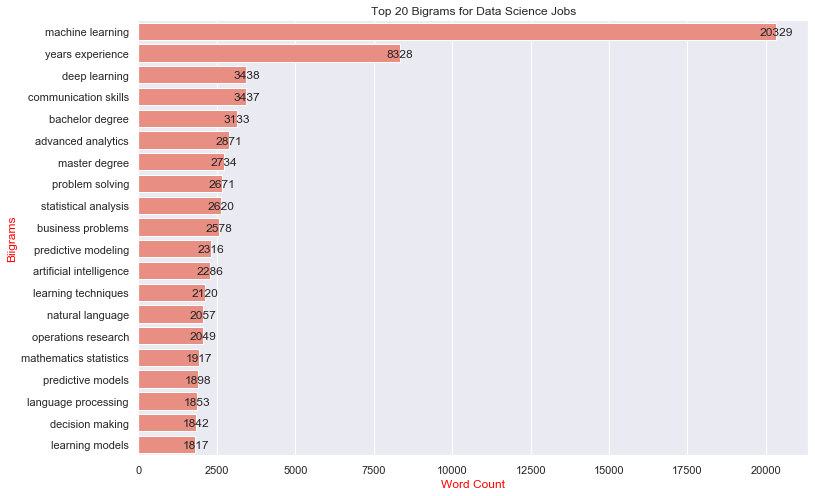

In [35]:
# bigram
phrase, count = ngrams_generator(descrip, 2, 20)

plt.figure(figsize=(12,8))

sns.set(style="darkgrid")
sns.set_color_codes("muted")

# Create barplot 
ax = sns.barplot(count, phrase, color="salmon", orient='h')
# Annotate every single Bar with its value, based on it's width           
for p in ax.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')
plt.xlabel("Word Count", fontsize=12, color='red' )
plt.ylabel("Biigrams", fontsize=12, color='red')
plt.title("Top 20 Bigrams for Data Science Jobs")
plt.show()



In [ ]:
# trigram
phrase, count = ngrams_generator(descrip, 3, 20)

plt.figure(figsize=(12,8))

sns.set(style="darkgrid")
sns.set_color_codes("muted")

# Create barplot 
ax = sns.barplot(count, phrase, color="salmon", orient='h')
# Annotate every single Bar with its value, based on it's width           
for p in ax.patches:
    width = p.get_width()
    plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.0f}'.format(width),
             ha='center', va='center')
plt.xlabel("Word Count", fontsize=12, color='red')
plt.ylabel("tigrams", fontsize=12, color='red')
plt.title("Top 20 Trigrams for Data Science Jobs")
plt.show()

In [ ]:
# five gram
phrase, count = ngrams_generator(descrip, 4, 20)

plt.figure(figsize=(12,8))
seaborn.barplot(count, phrase)
plt.xlabel("Word Count", fontsize=12, color='red')
plt.ylabel("Five grams", fontsize=12, color='red')
plt.title("Top 20 Trigrams for Data Science Jobs")
plt.show()

### TF-IDF

In [ ]:
# drop minority groups
new_data =  data[data.category != 'other']
new_data = new_data[data.category != 'agriculture']
new_data = new_data[data.category != 'arts & entertainment']
new_data = new_data[data.category != 'real estate & construction']

In [ ]:
new_data['category'].unique()

In [ ]:
mapping = {'financial services':0, \
          'life sciences & healthcare':1, \
          'transportation, manufacturing, and operations management':2, \
          'government services & security':3, \
          'engineering & technology':4, \
          'human services':5, \
          'sales & marketing':6, \
          'legal affairs':7, \
          'management, administration, & consulting':8, \
          'education': 9}

In [ ]:
new_data['category'] = new_data['category'].map(mapping)
new_data.head()

## 3. Machine Learning

### K-means

### Random Forest

### DBScan